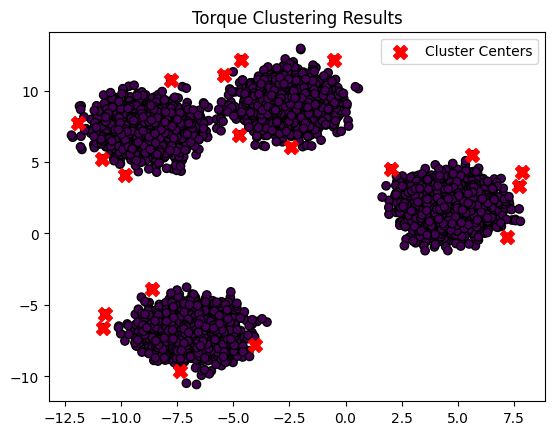

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from scipy.spatial import KDTree

class TorqueClustering:
    def __init__(self):
        self.clusters = None
        self.cluster_centers = None

    def fit(self, X):
        """Perform Torque Clustering on dataset X."""
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}  
        masses = {i: 1 for i in range(n_samples)}  

        # Compute pairwise distances
        distances = cdist(X, X, metric="euclidean")
        np.fill_diagonal(distances, np.inf)  
        
        # Step 1: Merge nearest neighbor with higher mass
        connections = {}
        for i in range(n_samples):
            nearest = np.argmin(distances[i])
            if masses[i] <= masses[nearest]:
                connections[i] = nearest  # Merge rule

        # Create a graph structure
        graph = {i: [connections[i]] for i in connections}

        # Step 2: Compute Torque for each connection
        torques = {}
        for i in connections:
            j = connections[i]
            mass_product = masses[i] * masses[j]
            distance_sq = distances[i, j] ** 2
            torques[(i, j)] = mass_product * distance_sq

        # Step 3: Identify abnormal connections using Torque Gap
        sorted_torques = sorted(torques.items(), key=lambda x: x[1], reverse=True)
        torque_values = np.array([t[1] for t in sorted_torques])
        torque_gaps = np.diff(torque_values)

        # Find the largest torque gap
        if len(torque_gaps) > 0:
            abnormal_index = np.argmax(torque_gaps)
            abnormal_connections = sorted_torques[:abnormal_index + 1]
        else:
            abnormal_connections = []

        # Step 4: Remove abnormal connections
        for (i, j), _ in abnormal_connections:
            if i in graph:
                del graph[i]

        # Step 5: Assign clusters
        cluster_labels = np.zeros(n_samples, dtype=int)
        cluster_map = {}
        cluster_count = 0
        for i in range(n_samples):
            if i not in graph:
                if i not in cluster_map:
                    cluster_map[i] = cluster_count
                    cluster_count += 1
                cluster_labels[i] = cluster_map[i]

        # Store results
        self.clusters = cluster_labels
        self.cluster_centers = [X[i] for i in cluster_map]

        return cluster_labels

    def plot_clusters(self, X):
        """Visualize the clusters"""
        plt.scatter(X[:, 0], X[:, 1], c=self.clusters, cmap="viridis", edgecolors="k")
        plt.scatter(np.array(self.cluster_centers)[:, 0], np.array(self.cluster_centers)[:, 1], 
                    c="red", marker="X", s=100, label="Cluster Centers")
        plt.legend()
        plt.title("Torque Clustering Results")
        plt.show()

# Generate Sample Data
X, _ = make_blobs(n_samples=7000, centers=4, random_state=42, cluster_std=1)

# Run Torque Clustering
tc = TorqueClustering()
labels = tc.fit(X)

# Plot Clusters
tc.plot_clusters(X)


In [ ]:
@task
def call_llm_1(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def call_llm_2(topic: str):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content


@task
def call_llm_3(topic):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content


@task
def aggregator(topic, joke, story, poem):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(
        topic, joke_fut.result(), story_fut.result(), poem_fut.result()
    ).result()

# Invoke
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")